# Zadanie domowe -- interpolacja dwusześcienna

Interpolacja dwusześcienna, to podobnie jak w przypadku interpolacji dwuliniowej, rozszerzenie idei interpolacji jednowymiarowej na dwuwymiarową siatkę.
W trakcie jej obliczania wykorzystywane jest 16 pikseli z otoczenia (dla dwuliniowej 4).
Skutkuje to zwykle lepszymi wynikami - obraz wyjściowy jest bardziej gładki i z mniejszą liczbą artefaktów.
Ceną jest znaczny wzrost złożoności obliczeniowej (zostało to zaobserwowane podczas ćwiczenia).

Interpolacja dana jest wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}

Zadanie sprowadza się zatem do wyznaczenia 16 współczynników $a_{ij}$.
W tym celu wykorzystuje się, oprócz wartość w puntach $A$ (0,0), $B$ (1 0), $C$ (1,1), $D$ (0,1) (por. rysunek dotyczący interpolacji dwuliniowej), także pochodne cząstkowe $A_x$, $A_y$, $A_{xy}$.
Pozwala to rozwiązać układ 16-tu równań.

Jeśli zgrupujemy parametry $a_{ij}$:
\begin{equation}
a = [ a_{00}~a_{10}~a_{20}~a_{30}~a_{01}~a_{11}~a_{21}~a_{31}~a_{02}~a_{12}~a_{22}~a_{32}~a_{03}~a_{13}~a_{23}~a_{33}]
\end{equation}

i przyjmiemy:
\begin{equation}
x = [A~B~D~C~A_x~B_x~D_x~C_x~A_y~B_y~D_y~C_y~A_{xy}~B_{xy}~D_{xy}~C_{xy}]^T
\end{equation}

To zagadnienie można opisać w postaci równania liniowego:
\begin{equation}
Aa = x
\end{equation}
gdzie macierz $A^{-1}$ dana jest wzorem:

\begin{equation}
A^{-1} =
\begin{bmatrix}
1& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0 \\
0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
-3&  3&  0&  0& -2& -1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
2& -2&  0&  0&  1&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0& -3&  3&  0&  0& -2& -1&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  2& -2&  0&  0&  1&  1&  0&  0 \\
-3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0& -3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0 \\
9& -9& -9&  9&  6&  3& -6& -3&  6& -6&  3& -3&  4&  2&  2&  1 \\
-6&  6&  6& -6& -3& -3&  3&  3& -4&  4& -2&  2& -2& -2& -1& -1 \\
2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0 \\
-6&  6&  6& -6& -4& -2&  4&  2& -3&  3& -3&  3& -2& -1& -2& -1 \\
4& -4& -4&  4&  2&  2& -2& -2&  2& -2&  2& -2&  1&  1&  1&  1 \\
\end{bmatrix}
\end{equation}

Potrzebne w rozważaniach pochodne cząstkowe obliczane są wg. następującego przybliżenia (przykład dla punktu A):
\begin{equation}
A_x = \frac{I(i+1,j) - I(i-1,j)}{2}
\end{equation}

\begin{equation}
A_y = \frac{I(i,j+1) - I(i,j-1)}{2}
\end{equation}

\begin{equation}
A_{xy} = \frac{I(i+1,j+1) - I(i-1,j) - I(i,j-1) + I(i,j)}{4}
\end{equation}

## Zadanie

Wykorzystując podane informacje zaimplementuj interpolację dwusześcienną.
Uwagi:
- macierz $A^{-1}$ dostępna jest w pliku *a_invert.py*
- trzeba się zastanowić nad potencjalnym wykraczaniem poza zakres obrazka (jak zwykle).

Ponadto dokonaj porównania liczby operacji arytmetycznych i dostępów do pamięci koniecznych przy realizacji obu metod interpolacji: dwuliniowej i dwusześciennej.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import ainvert

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/"

fileName = "ainvert.py"
if not os.path.exists(fileName):
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, "wb").write(r.content)

In [2]:
def BicubicInterpolation(image, scale_width, scale_height):
    new_x, new_y = int(image.shape[0] * scale_width), int(image.shape[1] * scale_height)

    new_image = np.zeros((new_x, new_y), dtype=np.float32)

    def get_brightness_clamped(x, y):
        """
        Returns brightness of pixel at (x, y) position.
        If position is out of image, returns nearest pixel - one on the edge.
        """
        x = min(max(x, 0), image.shape[0] - 1)
        y = min(max(y, 0), image.shape[1] - 1)
        return image[x, y].astype(np.float32)

    for i in range(new_x):
        for j in range(new_y):
            scaled_x, scaled_y = i / scale_width, j / scale_height
            x, y = int(scaled_x), int(scaled_y)
            dx, dy = scaled_x - x, scaled_y - y
            x_nast, y_nast = x + 1, y + 1

            # Wartości w punktach A, B, C, D
            A = get_brightness_clamped(x, y)
            B = get_brightness_clamped(x_nast, y)
            C = get_brightness_clamped(x_nast, y_nast)
            D = get_brightness_clamped(x, y_nast)

            # POCHODNE
            # pochodne cząstkowe A_x, A_y, A_xy
            A_x = (
                get_brightness_clamped(x_nast, y) - get_brightness_clamped(x - 1, y)
            ) / 2
            A_y = (
                get_brightness_clamped(x, y_nast) - get_brightness_clamped(x, y - 1)
            ) / 2
            A_xy = (
                get_brightness_clamped(x_nast, y_nast)
                - get_brightness_clamped(x - 1, y_nast)
                - get_brightness_clamped(x, y - 1)
                + get_brightness_clamped(x, y)
            ) / 4

            # pochodne cząstkowe B_x, B_y, B_xy
            B_x = (
                get_brightness_clamped(x_nast + 1, y)
                - get_brightness_clamped(x_nast - 1, y)
            ) / 2
            B_y = (
                get_brightness_clamped(x_nast, y_nast)
                - get_brightness_clamped(x_nast, y - 1)
            ) / 2
            B_xy = (
                get_brightness_clamped(x_nast + 1, y_nast)
                - get_brightness_clamped(x_nast - 1, y_nast)
                - get_brightness_clamped(x_nast, y - 1)
                + get_brightness_clamped(x_nast, y)
            ) / 4

            # pochodne cząstkowe C_x, C_y, C_xy
            C_x = (
                get_brightness_clamped(x_nast + 1, y_nast)
                - get_brightness_clamped(x_nast - 1, y_nast)
            ) / 2
            C_y = (
                get_brightness_clamped(x_nast, y_nast + 1)
                - get_brightness_clamped(x_nast, y_nast - 1)
            ) / 2
            C_xy = (
                get_brightness_clamped(x_nast + 1, y_nast + 1)
                - get_brightness_clamped(x_nast - 1, y_nast + 1)
                - get_brightness_clamped(x_nast, y_nast - 1)
                + get_brightness_clamped(x_nast, y_nast)
            ) / 4

            # pochodne cząstkowe D_x, D_y, D_xy
            D_x = (
                get_brightness_clamped(x, y_nast)
                - get_brightness_clamped(x - 1, y_nast)
            ) / 2
            D_y = (
                get_brightness_clamped(x, y_nast + 1)
                - get_brightness_clamped(x, y_nast - 1)
            ) / 2
            D_xy = (
                get_brightness_clamped(x, y_nast + 1)
                - get_brightness_clamped(x - 1, y_nast + 1)
                - get_brightness_clamped(x, y_nast - 1)
                + get_brightness_clamped(x, y_nast)
            ) / 4

            # WEKTORY
            # wektor x
            x = np.array(
                [
                    [
                        A,
                        B,
                        D,
                        C,
                        A_x,
                        B_x,
                        D_x,
                        C_x,
                        A_y,
                        B_y,
                        D_y,
                        C_y,
                        A_xy,
                        B_xy,
                        D_xy,
                        C_xy,
                    ]
                ]
            ).T
            # wektor a
            a = ainvert.A_invert @ x

            # przekształcenie macierzy a do postaci 4x4
            A = a.reshape((4, 4))

            # wektory dx, dy
            dx_vec = np.array([[1, dx, dx**2, dx**3]])
            dy_vec = np.array([[1], [dy], [dy**2], [dy**3]])

            # obliczenie wartości piksela przy użyciu mnożenia macierzy
            new_image[i, j] = (dx_vec @ A.T @ dy_vec)[0, 0]

    # pobranie minimalnej i maksymalnej wartości piksela
    min_val = np.min(new_image)
    max_val = np.max(new_image)

    # rzutowanie do typu uint8 z przeskalowaniem wartości do zakresu 0-255
    new_image = ((new_image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    return new_image

True

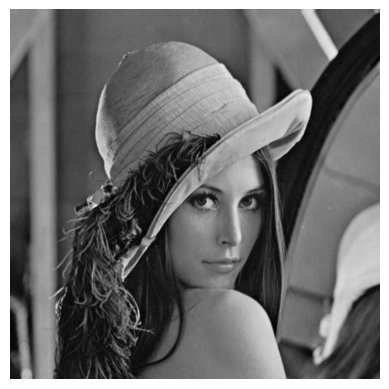

In [3]:
img = cv2.imread("lena.bmp", cv2.IMREAD_GRAYSCALE)

lena = BicubicInterpolation(img, 2.5, 2.5)
plt.imshow(lena, "gray")
plt.axis("off")

# save to file
cv2.imwrite("BiCubicInterpolation.png", lena)